https://gymnasium.farama.org/environments/box2d/lunar_lander/
Implementar Q Learning para esse env.

---
## Action Space
There are four discrete actions available:

0: do nothing
1: fire left orientation engine
2: fire main engine
3: fire right orientation engine

## Observation Space
The state is an 8-dimensional vector: the coordinates of the lander in x & y, its linear velocities in x & y, its angle, its angular velocity, and two booleans that represent whether each leg is in contact with the ground or not.

## Rewards
After every step a reward is granted. The total reward of an episode is the sum of the rewards for all the steps within that episode.
For each step, the reward:

is increased/decreased the closer/further the lander is to the landing pad.
is increased/decreased the slower/faster the lander is moving.
is decreased the more the lander is tilted (angle not horizontal).
is increased by 10 points for each leg that is in contact with the ground.
is decreased by 0.03 points each frame a side engine is firing.
is decreased by 0.3 points each frame the main engine is firing.

The episode receive an additional reward of -100 or +100 points for crashing or landing safely respectively.
An episode is considered a solution if it scores at least 200 points.

## Agente de Q Learning:
https://gymnasium.farama.org/introduction/train_agent/

## Tutoriais importantes!
https://gymnasium.farama.org/tutorials/training_agents/

In [1]:
import gymnasium as gym
import numpy as np

env = gym.make("LunarLander-v3") #, continuous=False, gravity=-10.0, enable_wind=False, wind_power=15.0, turbulence_power=1.5)

In [7]:
# Define bins per dimension for discretization
bins_per_dim = [6, 6, 6, 6, 6, 6, 2, 2] # num_states = 186 thousands
num_states = np.prod(bins_per_dim)
num_actions = env.action_space.n

Q = np.zeros((num_states, num_actions))  # Q(s, a) = Q[state, action]

discount = 1.0
alpha = 0.1
eps = .9
max_episodes = 100000

In [3]:
def discretize_observation(obs, bins_per_dim=None):
    """
    Discretizes the LunarLander observation into a single integer index.
    Args:
        obs: array-like, shape (8,)
        bins_per_dim: list or array of length 8, number of bins for each dimension
    Returns:
        int: unique discrete state index
    """
    # Define reasonable bounds for each dimension (from env source/documentation)
    low = np.array([-1.5, -0.5, -2.0, -2.0, -np.pi, -5.0, 0, 0])
    high = np.array([1.5, 1.5, 2.0, 2.0, np.pi, 5.0, 1, 1])
    obs = np.clip(obs, low, high)

    if bins_per_dim is None:
        bins_per_dim = [6, 6, 6, 6, 6, 6, 2, 2]  # 6 bins for continuous, 2 for booleans

    # Discretize each dimension
    discretized = []
    for i in range(8):
        if bins_per_dim[i] == 2:  # For leg contact (already 0 or 1)
            discretized.append(int(obs[i]))
        else:
            bins = np.linspace(low[i], high[i], bins_per_dim[i] + 1)
            discretized.append(np.digitize(obs[i], bins) - 1)
            discretized[-1] = min(discretized[-1], bins_per_dim[i] - 1)  # Ensure in range

    # Convert multi-dimensional bin to single integer (flattened index)
    state_idx = 0
    for i in range(8):
        state_idx *= bins_per_dim[i]
        state_idx += discretized[i]
    return state_idx

In [4]:
def get_action(s):
    if np.random.rand() < eps:
        return env.action_space.sample()
    else:
        return np.argmax(Q[s])

In [5]:
def q_update(s, a, r, s1, terminated):
    if terminated:
        max_q1 = 0
    else:
        max_q1 = np.max(Q[s1])

    target = r + discount * max_q1
    Q[s, a] += alpha * (target - Q[s, a])

In [8]:
import time  # Add timing
start_time = time.time()
for episode in range(max_episodes):
    observation, _ = env.reset()
    s = discretize_observation(observation) # Continuous to discrete

    # Make epsilon decay according to episode counter
    if eps > 0.01:
        eps *= 0.99
    
    while True:
        a = get_action(s)
        s1, r, terminated, truncated, _ = env.step(a)
        s1_d = discretize_observation(s1)  # Corrigir aqui
        q_update(s, a, r, s1_d, terminated)
        s = s1_d
        if terminated or truncated:
            break

env.close()
end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

KeyboardInterrupt: 

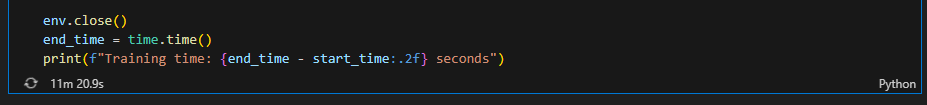
Muitos minutos e não terminou de rodar... Tentamos 1 Mi de episódios e baixamos para 100k e nada!



---
## Q-Learning no ambiente Taxi-v3

In [16]:
import gymnasium as gym
import numpy as np

env_taxi = gym.make('Taxi-v3')
num_states_taxi = env_taxi.observation_space.n
num_actions_taxi = env_taxi.action_space.n

Q_taxi = np.zeros((num_states_taxi, num_actions_taxi))

discount_taxi = 0.99
alpha_taxi = 0.1
eps_taxi = 0.9
max_episodes_taxi = 10000

In [17]:
def get_action_taxi(s):
    if np.random.rand() < eps_taxi:
        return env_taxi.action_space.sample()
    else:
        return np.argmax(Q_taxi[s])

In [18]:
def q_update_taxi(s, a, r, s1, terminated):
    if terminated:
        max_q1 = 0
    else:
        max_q1 = np.max(Q_taxi[s1])
    target = r + discount_taxi * max_q1
    Q_taxi[s, a] += alpha_taxi * (target - Q_taxi[s, a])

In [19]:
import time
start_time = time.time()
for episode in range(max_episodes_taxi):
    s, _ = env_taxi.reset()
    if eps_taxi > 0.01:
        eps_taxi *= 0.995
    while True:
        a = get_action_taxi(s)
        s1, r, terminated, truncated, _ = env_taxi.step(a)
        q_update_taxi(s, a, r, s1, terminated)
        s = s1
        if terminated or truncated:
            break
env_taxi.close()
end_time = time.time()
print(f"Taxi-v3 training time: {end_time - start_time:.2f} seconds")

Taxi-v3 training time: 2.34 seconds


In [20]:
import time

# Executa o modelo treinado no Taxi-v3 por 5 episódios com renderização
env_taxi = gym.make('Taxi-v3', render_mode='human')
for ep in range(5):
    s, _ = env_taxi.reset()
    done = False
    total_reward = 0
    while not done:
        a = np.argmax(Q_taxi[s])
        s, r, terminated, truncated, _ = env_taxi.step(a)
        total_reward += r
        done = terminated or truncated
        time.sleep(0.5)  # Para visualizar melhor cada passo
    print(f"Episódio {ep+1}: recompensa total = {total_reward}")
env_taxi.close()

Episódio 1: recompensa total = 8
Episódio 2: recompensa total = 9
Episódio 3: recompensa total = 8
Episódio 4: recompensa total = 5
Episódio 5: recompensa total = 12
